## Clustering micro-Raman for chemical mapping of ferroelectrics

Code by: Marti Checa

Publication: M.Checa et. al "Correlative Piezoresponse and Micro Raman Imaging of CuInP2S6 - In4/3P2S6 flakes unravels phase-specific phononic fingerprint via unsupervised learning", Applied Physics Letters (2022) 

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from renishawWiRE import WDFReader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.patches import Rectangle
import os
from celluloid import Camera

## Select Data

In [2]:
# filename can be string, file obj or `pathlib.Path`
filename = r"F:\ORNL\Raman experiment/Data_Example_microRaman_CIPS_IPS_flake.wdf"
reader = WDFReader(filename)
reader.print_info()

                   Title:	Simple mapping measurement 5
             WiRE version:	3.0.0.0
        Laser Wavelength:	783.6929417582977 nm
                   Count:	7776
                Capacity:	7776
      Point Per Spectrum:	575
               Scan Type:	Static
        Measurement Type:	Mapping
           Spectral Unit:	counts
              Xlist Unit:	1/cm
            Xlist Length:	575
              Ylist Unit:	px
            Ylist Length:	1
               Xpos Unit:	um
               Ypos Unit:	um


In [3]:
#We get the sizes of the imported file
spectra = reader.spectra
print(spectra.shape)
Xpix=spectra.shape[0]
Ypix=spectra.shape[1]
Raman_axis_size=spectra.shape[2]

(81, 96, 575)


In [4]:
#Select if images were taken in snake mode or not
snake=True

if snake == True:
    spectra[1::2,:,:] = spectra[1::2,::-1,:]

## Plot of the single spectra

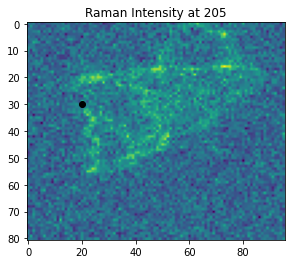

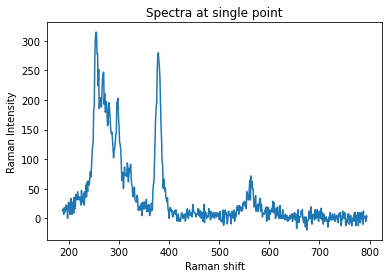

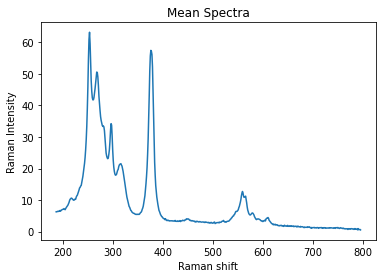

In [5]:
#We make a quick plot of the data to see how it looks like

Xpix_to_plot=20
Ypix_to_plot=30

Raman_number_to_plot=205

plt.imshow(spectra[:,:,Raman_number_to_plot].reshape((Xpix, Ypix)))
plt.scatter(Xpix_to_plot,Ypix_to_plot,color='k')
plt.title('Raman Intensity at '+str(Raman_number_to_plot))
plt.show()

plt.plot(np.flipud(reader.xdata),np.flipud(spectra[Xpix_to_plot,Ypix_to_plot,:]))
plt.title('Spectra at single point')
plt.xlabel('Raman shift')
plt.ylabel('Raman Intensity')
plt.show()

meanspectra=spectra.mean(axis=(0, 1))
meanspectra=np.flipud(meanspectra)

plt.plot(np.flipud(reader.xdata),meanspectra)
plt.title('Mean Spectra')
plt.xlabel('Raman shift')
plt.ylabel('Raman Intensity')

plt.show()

## Crop/Select a certain part of the image

In [6]:
#We decide if we want to crop a certain part of the image:

option=0 # 0 is no crop, 1 is crop (parameers of the crop are in the if option ==1)

spectra = reader.spectra
Xpix=spectra.shape[0]
Ypix=spectra.shape[1]

if option == 0:
    spectra_new=spectra
    Xpix_new=Xpix
    Ypix_new=Ypix
    print("You are good to go, no crop needed")
    
if option == 1:
    Xleft_crop=20
    Yhigh_crop=1
    Xpix_to_crop=12
    Ypix_to_crop=12
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(spectra[:,:,Raman_number_to_plot].reshape((Xpix, Ypix)))
    ax.add_patch(Rectangle((Xleft_crop, Yhigh_crop),Xpix_to_crop, Ypix_to_crop, linewidth=1, edgecolor='r', facecolor='none'))
    ax.set_title('Raman Intensity at '+str(Raman_number_to_plot))
    plt.show()
    
    Xpix_new=Xpix_to_crop
    Ypix_new=Ypix_to_crop
    spectra_new=spectra[Xleft_crop:(Xleft_crop+Xpix_to_crop),Yhigh_crop:(Yhigh_crop+Ypix_to_crop),:]
    #print(spectra_new.shape)

You are good to go, no crop needed


## K-means clustering

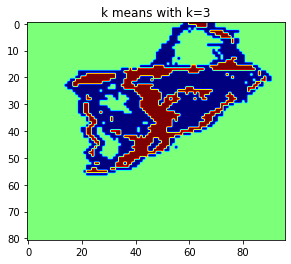

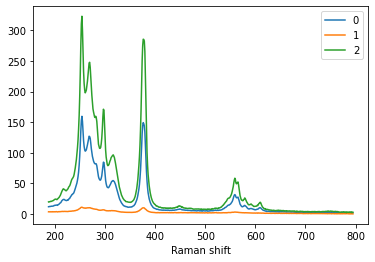

In [7]:
#build the data and normalize it ready for k-means use..
spectra=spectra_new
Xpix=Xpix_new
Ypix=Ypix_new

data_for_kmeans=spectra.reshape(Xpix*Ypix,Raman_axis_size)
scaler = StandardScaler()
scaler.fit(data_for_kmeans)
Normalized_Data = scaler.transform(data_for_kmeans)

# We now perform the k means algorithm with the optimal k
N=3
kmeans = KMeans(n_clusters=N, random_state=4, max_iter=2000, n_init=100).fit(Normalized_Data)
#Now I build the matrix with the different clusters:
labels=np.reshape(kmeans.labels_,(Xpix, Ypix))
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

#We plot the centroids
plt.imshow(labels,cmap='jet')
plt.title('k means with k='+str(N))
plt.show()

for i in range(N):
    plt.plot(np.flipud(reader.xdata),np.flipud(centroids[i,:]),label=str(i))
plt.xlabel('Raman shift')
plt.legend()
plt.show()

## PCA decomposition

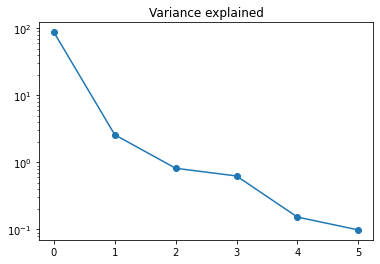

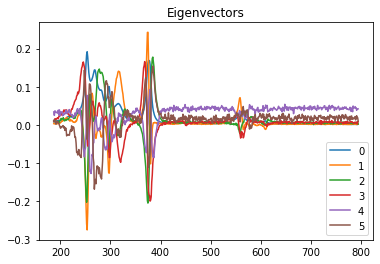

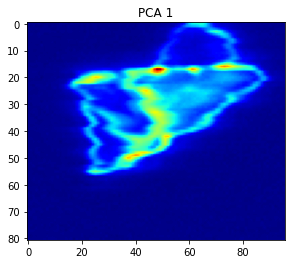

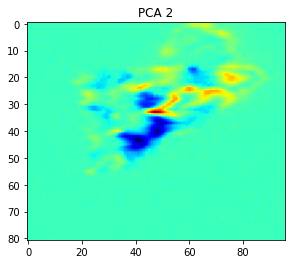

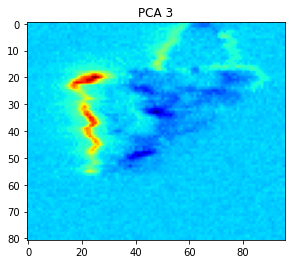

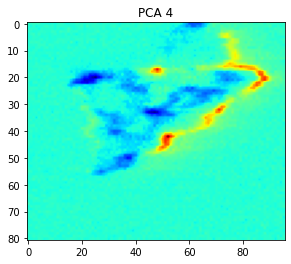

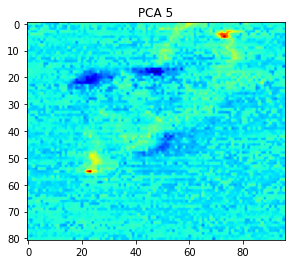

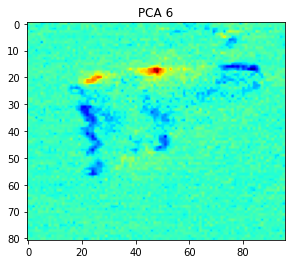

In [8]:
from sklearn.decomposition import PCA
n_components=6

pca = PCA(n_components=n_components)
pca.fit(data_for_kmeans)
eigenvalues=pca.fit_transform(data_for_kmeans)

#we plot the variance explained
plt.plot(100*pca.explained_variance_ratio_,'-o')
plt.yscale("log")  
plt.title('Variance explained')
plt.show()

#We plot the first 4 eigenvectors
for i in range(n_components):
    plt.plot(np.flipud(reader.xdata),np.flipud(pca.components_[i,:]),label=str(i))
plt.title('Eigenvectors')
plt.legend()
plt.show()

#We plot the first 4 eigenalues
for i in range(n_components):
    plt.imshow(eigenvalues[:,i].reshape((Xpix, Ypix)),cmap='jet')
    plt.title('PCA '+str(i+1))
    plt.show()


## k-means visualization of the PCA decomposition

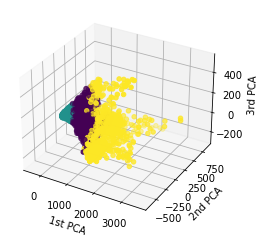

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(eigenvalues[:,0], eigenvalues[:,1], eigenvalues[:,2], c=kmeans.labels_)
ax.set_xlabel('1st PCA')
ax.set_ylabel('2nd PCA')
ax.set_zlabel('3rd PCA')

plt.show()

## Animation of the dataset

MovieWriter PillowWriter unavailable; using Pillow instead.


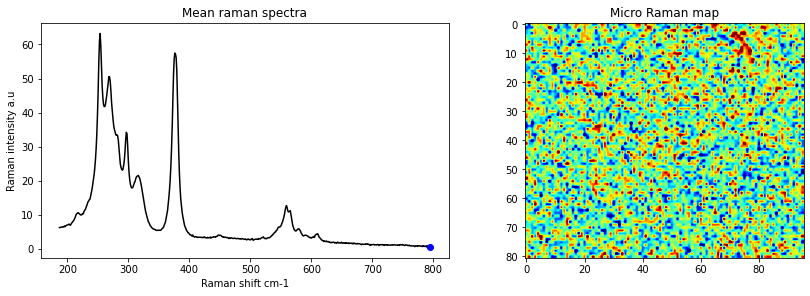

In [10]:
#path where we want to store the animation
os.chdir(r'F:\ORNL\Raman experiment/')

# create figure object
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4),constrained_layout=True)

ax1.set_xlabel('Raman shift cm-1')
ax1.set_ylabel('Raman intensity a.u')
ax1.set_title('Mean raman spectra')
ax2.set_title('Micro Raman map')

camera = Camera(f)
for i in range(Raman_axis_size):
    ax1.plot(np.flipud(reader.xdata),meanspectra,'k') 
    ax1.plot(reader.xdata[-i],(meanspectra[i]),'bo') 
    cax=ax2.imshow((spectra[:,:,-i].reshape((Xpix, Ypix))),vmin=(np.mean(spectra[:,:,-i])-2*np.std(spectra[:,:,-i])),vmax=(np.mean(spectra[:,:,-i])+2*np.std(spectra[:,:,-i])),cmap='jet') 
    camera.snap()

#f.colorbar(cax)
animation = camera.animate()
animation.save('Animation_CIPS_IPS_microRaman.gif', writer='PillowWriter', fps=10)